<a href="https://colab.research.google.com/github/ankur302/Fake-News-Classification-LSTM/blob/main/Fake_News_Classifier_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.preprocessing.text import one_hot 

In [37]:
train = pd.read_csv("/content/drive/MyDrive/My_Data/FakeNews/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/My_Data/FakeNews/test.csv")

In [38]:
train_df = train.drop("label",axis=1)

In [39]:
train_df["train/test"] = "train"
test_df["train/test"] = "test"

In [22]:
display(print(train_df.shape),train_df.head(),print(test_df.shape),test_df.head())

(20800, 5)
(5200, 5)


None

,id,title,author,text,train/test
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,train
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,train
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",train
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,train
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,train


None

,id,title,author,text,train/test
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",test
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,test
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,test
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",test
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,test


In [90]:
combined_df = pd.concat([train_df,test_df],axis=0)

## Data Preprocessing

In [91]:
combined_df = combined_df.drop(["id","title","author"],axis=1)

In [92]:
combined_df.isnull().sum()

text          46
train/test     0
dtype: int64

In [93]:
combined_df.fillna(' ',inplace=True)

In [ ]:
import nltk
nltk.download("all")


In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def cleaning(text):
  cleaned_text = re.sub("[^a-zA-Z]"," ",text)
  
  cleaned_text = cleaned_text.lower()
  
  cleaned_text = cleaned_text.split()
  
  cleaned_text = [lemmatizer.lemmatize(word) for word in cleaned_text if not word  in stopwords.words("english")] 
  
  cleaned_text  = ' '.join(cleaned_text)
  
  print('\n'*4,cleaned_text)
  
  return cleaned_text
combined_df['cleaned_text'] = combined_df['text'].apply(lambda x : cleaning(x))

In [98]:
combined_df

,text,train/test,cleaned_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,train,house dem aide even see comey letter jason cha...
1,Ever get the feeling your life circles the rou...,train,ever get feeling life circle roundabout rather...
2,"Why the Truth Might Get You Fired October 29, ...",train,truth might get fired october tension intellig...
3,Videos 15 Civilians Killed In Single US Airstr...,train,video civilian killed single u airstrike ident...
4,Print \nAn Iranian woman has been sentenced to...,train,print iranian woman sentenced six year prison ...
...,...,...,...
5195,Of all the dysfunctions that plague the world’...,test,dysfunction plague world megacities none may p...
5196,WASHINGTON — Gov. John Kasich of Ohio on Tu...,test,washington gov john kasich ohio tuesday signed...
5197,Good morning. (Want to get California Today by...,test,good morning want get california today email j...
5198,« Previous - Next » 300 US Marines To Be Deplo...,test,previous next u marine deployed russian border...


## Vector Representation Of the words

In [99]:
train_df = combined_df[combined_df['train/test']=='train']
test_df = combined_df[combined_df['train/test']=='test']

In [105]:
from keras.preprocessing.text import one_hot
vocab_size= 10000

def one_hot_func(data):
  sentence = []
  for i in range(0,len(data)):
    sentence.append(data["cleaned_text"][i])
  encoded = [one_hot(word,vocab_size) for word in sentence]
  return encoded

one_hot_encode_train = one_hot_func(train_df)
one_hot_encode_test = one_hot_func(test_df)


# Text Padding

In [116]:
from keras.preprocessing.sequence import pad_sequences
text_length= 1000

# applying padding to one-hot encoded train_data
train_padded= pad_sequences(one_hot_encode_train, padding= "pre", maxlen=text_length)

# applying padding to one-hot encoded test_data
test_padded= pad_sequences(one_hot_encode_test, padding= "pre", maxlen=text_length)

## Model Creation

In [118]:
X = np.array(train_padded)
y = np.array(train.label)

In [119]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=42)

In [122]:
from keras.layers import Dropout
embedding_vector_features = 50
model = Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length = text_length))
model.add(Dropout(0.25))

model.add(LSTM(250))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 50)          500000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 50)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 250)               301000    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 251       
Total params: 801,251
Trainable params: 801,251
Non-trainable params: 0
_________________________________________________________________


In [123]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=100)

Epoch 1/10
140/140 [==============================] - 1026s 7s/step - loss: 0.6089 - accuracy: 0.6511 - val_loss: 0.4347 - val_accuracy: 0.8307
Epoch 2/10
140/140 [==============================] - 1061s 8s/step - loss: 0.4415 - accuracy: 0.7866 - val_loss: 0.2441 - val_accuracy: 0.9095
Epoch 3/10
140/140 [==============================] - 1049s 7s/step - loss: 0.4465 - accuracy: 0.7900 - val_loss: 0.2762 - val_accuracy: 0.8829
Epoch 4/10
140/140 [==============================] - 1040s 7s/step - loss: 0.3395 - accuracy: 0.8563 - val_loss: 0.3688 - val_accuracy: 0.8287
Epoch 5/10
140/140 [==============================] - 1067s 8s/step - loss: 0.2508 - accuracy: 0.8994 - val_loss: 0.2699 - val_accuracy: 0.9034
Epoch 6/10
140/140 [==============================] - 1053s 8s/step - loss: 0.1635 - accuracy: 0.9383 - val_loss: 0.2811 - val_accuracy: 0.8830
Epoch 7/10
140/140 [==============================] - 1048s 7s/step - loss: 0.1396 - accuracy: 0.9464 - val_loss: 0.2831 - val_accuracy:

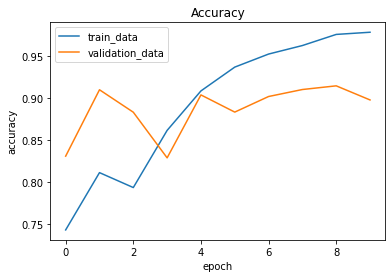

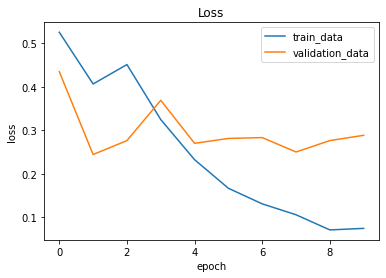

In [127]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs= range(len(history.history["accuracy"]))
# accuracy plot
plt.plot(epochs, history.history["accuracy"])
plt.plot(epochs, history.history["val_accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy")
plt.legend(["train_data", "validation_data"])
plt.show()

# loss plot
plt.plot(epochs, history.history["loss"])
plt.plot(epochs, history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss")
plt.legend(["train_data", "validation_data"])
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f072c033850>)

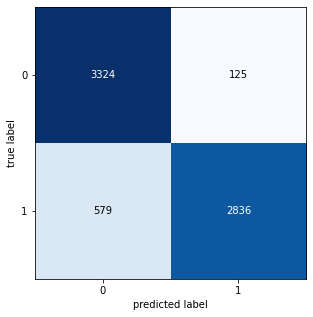

In [135]:
pred_val= model.predict_classes(X_test)

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm= confusion_matrix(y_test, pred_val)
plot_confusion_matrix(cm, figsize=(5,5))

In [147]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,pred_val)

0.8974358974358975